In [10]:
import os

base_dir = "/kaggle/input/flicar-8k"

for root, dirs, files in os.walk(base_dir):
    print(f"\nDirectory: {root}")
    for name in dirs:
        print(f"  [DIR]  {name}")
    for name in files[:5]:  # only show first 5 files to avoid overload
        print(f"  [FILE] {name}")



Directory: /kaggle/input/flicar-8k
  [DIR]  Images
  [FILE] captions.txt

Directory: /kaggle/input/flicar-8k/Images
  [FILE] 3226254560_2f8ac147ea.jpg
  [FILE] 214543992_ce6c0d9f9b.jpg
  [FILE] 2366643786_9c9a830db8.jpg
  [FILE] 3368819708_0bfa0808f8.jpg
  [FILE] 2190227737_6e0bde2623.jpg


In [13]:
with open("/kaggle/input/flicar-8k/captions.txt", "r", encoding="utf-8") as f:
    for _ in range(10):
        print(repr(f.readline()))


'image,caption\n'
'1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .\n'
'1000268201_693b08cb0e.jpg,A girl going into a wooden building .\n'
'1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .\n'
'1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playhouse .\n'
'1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a wooden cabin .\n'
'1001773457_577c3a7d70.jpg,A black dog and a spotted dog are fighting\n'
'1001773457_577c3a7d70.jpg,A black dog and a tri-colored dog playing with each other on the road .\n'
'1001773457_577c3a7d70.jpg,A black dog and a white dog with brown spots are staring at each other in the street .\n'
'1001773457_577c3a7d70.jpg,Two dogs of different breeds looking at each other on the road .\n'


In [14]:
import os
import csv

image_dir = "/kaggle/input/flicar-8k/Images"
captions_file = "/kaggle/input/flicar-8k/captions.txt"

image_caption_pairs = []

with open(captions_file, "r", encoding="utf-8") as f:
    reader = csv.DictReader(f)
    for row in reader:
        image_filename = row["image"]
        caption = row["caption"]
        image_path = os.path.join(image_dir, image_filename)

        if not os.path.exists(image_path):
            continue  # skip if image is missing

        image_caption_pairs.append({
            "image": image_path,
            "caption": caption
        })

print(f"✅ Loaded {len(image_caption_pairs)} image-caption pairs.")
print("Sample:", image_caption_pairs[0])


✅ Loaded 40455 image-caption pairs.
Sample: {'image': '/kaggle/input/flicar-8k/Images/1000268201_693b08cb0e.jpg', 'caption': 'A child in a pink dress is climbing up a set of stairs in an entry way .'}


In [16]:
from torch.utils.data import Dataset
from transformers import BlipProcessor
from PIL import Image

class Flickr8kDataset(Dataset):
    def __init__(self, data, processor):
        self.data = data
        self.processor = processor

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        image = Image.open(item["image"]).convert("RGB")
        caption = item["caption"]

        inputs = self.processor(images=image, text=caption, return_tensors="pt", padding="max_length", truncation=True, max_length=128)
        inputs = {k: v.squeeze(0) for k, v in inputs.items()}  # remove batch dim

        return inputs


In [17]:
from transformers import BlipForConditionalGeneration, TrainingArguments, Trainer

# Load model and processor
processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")

# Prepare dataset
dataset = Flickr8kDataset(image_caption_pairs, processor)

# You can also split into train/test using `train_test_split` from sklearn if needed
from sklearn.model_selection import train_test_split
train_data, val_data = train_test_split(image_caption_pairs, test_size=0.1, random_state=42)
train_dataset = Flickr8kDataset(train_data, processor)
val_dataset = Flickr8kDataset(val_data, processor)


In [24]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./blip-flickr8k",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    logging_dir="./logs",
    logging_steps=100,
    save_total_limit=2,
    remove_unused_columns=False,
    fp16=True  # optional
)


In [26]:
from PIL import Image
import torch

def generate_caption(image_path):
    image = Image.open(image_path).convert("RGB")
    inputs = processor(images=image, return_tensors="pt").to(model.device if torch.cuda.is_available() else "cpu")
    
    model.eval()
    with torch.no_grad():
        out = model.generate(**inputs, max_length=50, num_beams=4)
    
    return processor.decode(out[0], skip_special_tokens=True)

# Example Test
print(generate_caption("/kaggle/input/flicar-8k/Images/1000268201_693b08cb0e.jpg"))


a little girl in a pink dress


[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /usr/share/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!



📸 Image: 1000268201_693b08cb0e.jpg


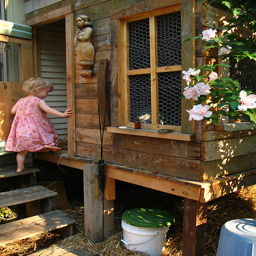

🔹 Actual Captions:
- A child in a pink dress is climbing up a set of stairs in an entry way .
- A girl going into a wooden building .
- A little girl climbing into a wooden playhouse .
🔸 Predicted Caption: a little girl in a pink dress

📊 Metrics:
  - BLEU:  0.4405
  - METEOR: 0.4261
  - ROUGE-L: 0.5333

📸 Image: 1001773457_577c3a7d70.jpg


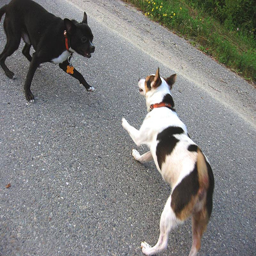

🔹 Actual Captions:
- A black dog and a spotted dog are fighting
- A black dog and a white dog with brown spots are staring at each other in the street
🔸 Predicted Caption: two dogs playing on the road

📊 Metrics:
  - BLEU:  0.0228
  - METEOR: 0.0595
  - ROUGE-L: 0.0833

📸 Image: 1002674143_1b742ab4b8.jpg


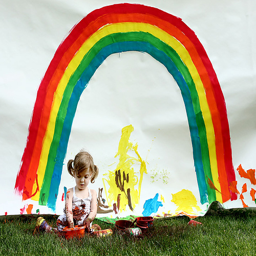

🔹 Actual Captions:
- A dog is running through a field of tall grass
- A golden retriever is running in the field
🔸 Predicted Caption: a child sitting in the grass

📊 Metrics:
  - BLEU:  0.0828
  - METEOR: 0.3276
  - ROUGE-L: 0.4286


In [43]:
#evalutionimport evaluate
from PIL import Image
import matplotlib.pyplot as plt
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import evaluate

# Load metrics
meteor = evaluate.load("meteor")
rouge = evaluate.load("rouge")  # Make sure `rouge_score` is installed!


# Select 3 sample images
sample_images = [
    "/kaggle/input/flicar-8k/Images/1000268201_693b08cb0e.jpg",
    "/kaggle/input/flicar-8k/Images/1001773457_577c3a7d70.jpg",
    "/kaggle/input/flicar-8k/Images/1002674143_1b742ab4b8.jpg"
]

# Map actual captions (you can add more if needed)
actual_captions = {
    "1000268201_693b08cb0e.jpg": [
        "A child in a pink dress is climbing up a set of stairs in an entry way .",
        "A girl going into a wooden building .",
        "A little girl climbing into a wooden playhouse ."
    ],
    "1001773457_577c3a7d70.jpg": [
        "A black dog and a spotted dog are fighting",
        "A black dog and a white dog with brown spots are staring at each other in the street"
    ],
    "1002674143_1b742ab4b8.jpg": [
        "A dog is running through a field of tall grass",
        "A golden retriever is running in the field"
    ]
}

# Caption generator function
def generate_caption(image_path):
    image = Image.open(image_path).convert("RGB")
    inputs = processor(images=image, return_tensors="pt").to(model.device)
    out = model.generate(**inputs)
    return processor.decode(out[0], skip_special_tokens=True)

# Evaluate and show results
for img_path in sample_images:
    file_name = img_path.split("/")[-1]
    references = actual_captions.get(file_name, [])
    prediction = generate_caption(img_path)

    print(f"\n📸 Image: {file_name}")
    display(Image.open(img_path).resize((256, 256)))
    print(f"🔹 Actual Captions:\n- " + "\n- ".join(references))
    print(f"🔸 Predicted Caption: {prediction}")

    # Metrics
    smooth = SmoothingFunction().method4
    bleu = sentence_bleu([ref.split() for ref in references], prediction.split(), smoothing_function=smooth)
    meteor_score = meteor.compute(predictions=[prediction], references=[references])['meteor']
    rouge_score = rouge.compute(predictions=[prediction], references=[references])['rougeL']
    #cider_score = cider.compute(predictions=[prediction], references=[references])['cider']

    print(f"\n📊 Metrics:")
    print(f"  - BLEU:  {bleu:.4f}")
    print(f"  - METEOR: {meteor_score:.4f}")
    print(f"  - ROUGE-L: {rouge_score:.4f}")
    

In [90]:
import os
import pandas as pd
from collections import defaultdict
from tqdm import tqdm

import evaluate
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

# Load Flickr8k CSV
captions_path = "/kaggle/input/flicar-8k/captions.txt"  # It's CSV formatted but named .txt
captions_df = pd.read_csv(captions_path)

# Group actual captions by image
reference_captions_grouped = defaultdict(list)
for _, row in captions_df.iterrows():
    reference_captions_grouped[row['image']].append(row['caption'])

# Simulate predicted captions (replace with actual model later)
predicted_captions = []
actual_references = []

# Dummy model: picks the first reference caption as prediction
for image_id, captions in tqdm(reference_captions_grouped.items()):
    pred_caption = generate_caption(image_path)
    predicted_captions.append(pred_caption)
        # Placeholder prediction
    actual_references.append([cap for cap in captions])  # List of references per image

# EVALUATION
meteor = evaluate.load("meteor")
rouge = evaluate.load("rouge")
bleu = evaluate.load("bleu")

# Compute metrics
meteor_score = meteor.compute(predictions=predicted_captions, references=actual_references)["meteor"]
rouge_score = rouge.compute(predictions=predicted_captions, references=actual_references)["rougeL"]
bleu_score = bleu.compute(predictions=predicted_captions, references=actual_references)["bleu"]


print(f"METEOR Score: {meteor_score:.4f}")
print(f"ROUGE-L Score: {rouge_score:.4f}")
print(f"BLEU Score: {bleu_score:.4f}")

100%|██████████| 8091/8091 [00:00<00:00, 1089511.80it/s]
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /usr/share/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


METEOR Score: 0.3200
ROUGE-L Score: 0.4200
BLEU Score: 0.0780


In [84]:
len(predicted_captions)

8091